In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio
from tqdm import tqdm

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pathlength_tuning/1_code/')
from func import set_proj_env, my_get_cmap, rank_int

In [3]:
parc_str = 'schaefer' # 'schaefer' 'lausanne' 'glasser'
parc_scale = 400 # 200/400 | 125/250 | 360
edge_weight = 'streamlineCount' # 'streamlineCount' 'volNormStreamline'
set_proj_env()

('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/0_data',
 '/Volumes/work_ssd/research_data/PNC/',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline',
 '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output')

In [4]:
# output file prefix
outfile_prefix = parc_str+'_'+str(parc_scale)+'_'+edge_weight+'_'
outfile_prefix

'schaefer_400_streamlineCount_'

### Setup directory variables

In [5]:
print(os.environ['PIPELINEDIR'])
if not os.path.exists(os.environ['PIPELINEDIR']): os.makedirs(os.environ['PIPELINEDIR'])

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline


In [6]:
outputdir = os.path.join(os.environ['PIPELINEDIR'], '0_get_sample', 'out')
print(outputdir)
if not os.path.exists(outputdir): os.makedirs(outputdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/2_pipeline/0_get_sample/out


In [7]:
figdir = os.path.join(os.environ['OUTPUTDIR'], 'figs')
print(figdir)
if not os.path.exists(figdir): os.makedirs(figdir)

/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/3_output/figs


In [8]:
# Parcellation specifications
if parc_str == 'schaefer':
    # Names of parcels
    parcel_names = np.genfromtxt(os.path.join(os.environ['PROJDIR'], 'figs_support/labels/schaefer' + str(parc_scale) + 'NodeNames.txt'), dtype='str')
    num_parcels = parcel_names.shape[0]
    
    scdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/diffusion/deterministic_20171118')
    sc_name_tmp = 'bblid/*xscanid/tractography/connectivity/bblid_*xscanid_SchaeferPNC_' + str(parc_scale) + '_dti_' + edge_weight + '_connectivity.mat'
elif parc_str == 'glasser':
    parcel_names = np.genfromtxt(os.path.join(os.environ['PROJDIR'], 'figs_support/labels/glasser' + str(parc_scale) + 'NodeNames.txt'), dtype='str')
    num_parcels = parcel_names.shape[0]

    scdir = os.path.join(os.environ['DERIVSDIR'], 'processedData/diffusion/deterministic_dec2016', edge_weight, 'GlasserPNC')
    sc_name_tmp = 'scanid_' + edge_weight + '_GlasserPNC.mat'

# Load in demographic and symptom data

In [9]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/dti/n1601_dti_qa_20170301.csv'))
# Rest QA
rest_qa = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/rest/n1601_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))
# Clinical diagnostic 
clinical = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/clinical/n1601_goassess_psych_summary_vars_20131014.csv'))
clinical_ps = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/clinical/n1601_diagnosis_dxpmr_20170509.csv'))
# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))
# Cognition
cnb = pd.read_csv(os.path.join(os.environ['DATADIR'], 'external/pncDataFreeze20170905/n1601_dataFreeze/cnb/n1601_cnb_factor_scores_tymoore_20151006.csv'))

# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol
df = pd.merge(df, clinical, on=['scanid', 'bblid']) # clinical
df = pd.merge(df, clinical_ps, on=['scanid', 'bblid']) # clinical
df = pd.merge(df, goassess, on=['bblid']) # goassess
df = pd.merge(df, cnb, on=['scanid', 'bblid']) # goassess

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


# Filter subjects

In [10]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df['t1Exclude'] == 0]
print('N after T1 exclusion:', df.shape[0])

# 3) Diffusion exclusion
df = df[df['b0ProtocolValidationStatus'] == 1]
df = df[df['dti64ProtocolValidationStatus'] == 1]
df = df[df['dti64Exclude'] == 0]
print('N after Diffusion exclusion:', df.shape[0])

# 4) Medicated
df = df[df['psychoactiveMedPsychv2'] == 0]
print('N after medication exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1394
N after Diffusion exclusion: 1100
N after medication exclusion: 978


In [11]:
df['dti64QAManualScore'].unique()

array([2., 1.])

In [12]:
np.sum(df['averageManualRating'] == 2)

835

In [13]:
np.sum(df['dti64QAManualScore'] == 2)

604

In [14]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

In [15]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

There are 143 unique age points


# Define discovery and replication splits

In [16]:
df['disc_repl'] = np.zeros(df.shape[0]).astype(int)

n=np.round(df.shape[0]*.5).astype(int)
print(n)

hold_out = df.sample(n=n, random_state=0, replace=False, axis=0).index
df.loc[hold_out,'disc_repl'] = 1
print('Train:', np.sum(df['disc_repl'] == 0), 'Test:', np.sum(df['disc_repl'] == 1))

489
Train: 489 Test: 489


## Symptom dimensions

In [17]:
# phenos = ['Overall_Psychopathology','Psychosis_Positive','F3_Executive_Efficiency','Overall_Speed']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear','F1_Exec_Comp_Res_Accuracy','F3_Executive_Efficiency','Overall_Speed']
print(phenos)

['Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear', 'F1_Exec_Comp_Res_Accuracy', 'F3_Executive_Efficiency', 'Overall_Speed']


#### Check for Nans

In [18]:
for pheno in phenos:
    if df.loc[:,pheno].isna().any():
        print('NaN replacement: ', pheno)
        x = np.nanmedian(df.loc[:,pheno])
        df.loc[df.loc[:,pheno].isna(),pheno] = x

NaN replacement:  F1_Exec_Comp_Res_Accuracy
NaN replacement:  F3_Executive_Efficiency
NaN replacement:  Overall_Speed


#### Normalize

In [19]:
rank_r = np.zeros(len(phenos),)

for i, pheno in enumerate(phenos):
    # normalize regional metric
#     x = sp.stats.yeojohnson(df.loc[:,pheno])[0]
    x = rank_int(df.loc[:,pheno])
    # check if rank order is preserved
    rank_r[i] = sp.stats.spearmanr(df.loc[:,pheno],x)[0]
    # store normalized version
    df.loc[:,pheno] = x

print(np.sum(rank_r < 1))

6


In [20]:
df.loc[:,phenos].var()

Overall_Psychopathology      0.982100
Psychosis_Positive           0.996701
Psychosis_NegativeDisorg     0.996702
AnxiousMisery                0.996701
Externalizing                0.996698
Fear                         0.996690
F1_Exec_Comp_Res_Accuracy    0.996714
F3_Executive_Efficiency      0.996714
Overall_Speed                0.996714
dtype: float64

## Load in structural connectivity matrices

In [21]:
# Missing data file for this subject only for schaefer 200
if parc_scale == 200:
    df.drop(labels = (112598, 5161), inplace=True)

In [22]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [23]:
A = np.zeros((num_parcels, num_parcels, df.shape[0]))
for (i, (index, row)) in enumerate(df.iterrows()):
    file_name = sc_name_tmp.replace("scanid", str(index[1]))
    file_name = file_name.replace("bblid", str(index[0]))
    full_path = glob.glob(os.path.join(scdir, file_name))
    if i == 0: print(full_path)
    if len(full_path) > 0:
        mat_contents = sio.loadmat(full_path[0])
        if edge_weight == 'streamlineCount':
            a = mat_contents['connectivity']
        elif edge_weight == 'volNormStreamline':
            a = mat_contents['volNorm_connectivity']
        if parc_str == 'lausanne' and parc_variant == 'cortex_only':
            a = a[parcel_loc == 1,:]
            a = a[:,parcel_loc == 1]
        A[:,:,i] = a
    elif len(full_path) == 0:
        print(file_name + ': NOT FOUND')
        subj_filt[i] = True
        A[:,:,i] = np.full((num_parcels, num_parcels), np.nan)

['/Volumes/work_ssd/research_data/PNC/processedData/diffusion/deterministic_20171118/81287/20100114x2738/tractography/connectivity/81287_20100114x2738_SchaeferPNC_400_dti_streamlineCount_connectivity.mat']


In [24]:
np.sum(subj_filt)

0

In [25]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]

### Check if any subjects have disconnected nodes in A matrix

In [26]:
# subject filter
subj_filt = np.zeros((df.shape[0],)).astype(bool)

In [27]:
for i in range(A.shape[2]):
    if np.any(np.sum(A[:,:,i], axis = 1) == 0):
        subj_filt[i] = True

In [28]:
np.sum(subj_filt)

60

In [29]:
if any(subj_filt):
    A = A[:,:,~subj_filt]
    df = df.loc[~subj_filt]
print(df.shape, A.shape)

(918, 238) (400, 400, 918)


In [30]:
np.sum(df['averageManualRating'] == 2)

783

In [31]:
np.sum(df['dti64QAManualScore'] == 2)

569

### Get streamline count and network density

In [32]:
A_c = np.zeros((A.shape[2],))
A_d = np.zeros((A.shape[2],))
for i in range(A.shape[2]):
    A_c[i] = np.sum(np.triu(A[:,:,i]))
    A_d[i] = np.count_nonzero(np.triu(A[:,:,i]))/((A[:,:,i].shape[0]**2-A[:,:,i].shape[0])/2)
df.loc[:,'streamline_count'] = A_c
df.loc[:,'network_density'] = A_d

In [33]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar,ageAtScan1_Years,disc_repl,streamline_count,network_density
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,1,0,0,0,0,0,0,0,0,0,...,1.601508,0.830148,0.514279,0.391313,-0.105869,-0.156787,20.0,0,294415.0,0.064173
81754,2740,1,0,0,0,0,0,0,0,1,0,...,1.134216,0.677509,1.006161,1.177551,0.935206,1.335039,19.3,1,269473.0,0.067594
81903,2749,1,0,0,0,0,0,0,0,0,0,...,1.886781,1.634455,0.527513,0.783375,1.272440,0.333475,19.2,1,224511.0,0.060877
81043,2750,1,0,0,0,0,0,0,0,0,0,...,0.261837,0.306490,0.001343,0.748104,1.059229,0.370116,20.8,0,270865.0,0.065451
81939,2751,1,0,0,0,0,0,0,0,1,0,...,0.566979,1.243338,-0.545969,0.593303,0.802772,-0.940102,19.5,0,279333.0,0.062769


## Export

In [34]:
header = ['disc_repl', 'squeakycleanExclude', 'ageAtScan1', 'ageAtScan1_Years', 'sex', 'race2', 'handednessv2',
          'averageManualRating', 'dti64QAManualScore', 'restProtocolValidationStatus', 'restExclude', 'dti64MeanAbsRMS','dti64MeanRelRMS','dti64MaxAbsRMS','dti64MaxRelRMS','mprage_antsCT_vol_TBV',
          'goassessSmryMood', 'goassessSmryMan', 'goassessSmryDep', 'goassessSmryEat', 'goassessSmryBul', 'goassessSmryAno', 'goassessSmryAnx', 'goassessSmryGad', 'goassessSmrySep',
          'goassessSmryPhb', 'goassessSmrySoc', 'goassessSmryPan', 'goassessSmryAgr', 'goassessSmryOcd', 'goassessSmryPtd', 'goassessSmryPsy', 'goassessSmryDel', 'goassessSmryHal',
          'goassessSmryHalAv', 'goassessSmryHalAs', 'goassessSmryHalVh', 'goassessSmryHalOh', 'goassessSmryHalTh', 'goassessSmryBeh', 'goassessSmryAdd', 'goassessSmryOdd', 'goassessSmryCon',
          'goassessSmryPrimePos1', 'goassessSmryPrimeTot', 'goassessSmryPrimePos2', 'goassessSmryPsychOverallRtg', 'goassessDxpmr4',
          'streamline_count', 'network_density'] + phenos
df.to_csv(os.path.join(outputdir, outfile_prefix+'df.csv'), columns = header)

### Export A matrices

In [35]:
for i in tqdm(np.arange(0,df.shape[0])):
    label = str(df.iloc[i,:].name[0])+'_'+str(df.iloc[i,:].name[1])+'_'
    np.save(os.path.join(outputdir, outfile_prefix+label+'A'), A[:,:,i])

100%|██████████| 918/918 [00:04<00:00, 208.70it/s]


In [36]:
np.save(os.path.join(outputdir, outfile_prefix+'A'), A)

In [37]:
mean_spars = np.round(df.loc[df['disc_repl'] == 0,'network_density'].mean(),2)
print(mean_spars)

0.06


In [38]:
sparity = np.round([mean_spars-0.02, mean_spars-0.01,
                    mean_spars,
                    mean_spars+0.01, mean_spars+0.02],2)
sparity

array([0.04, 0.05, 0.06, 0.07, 0.08])

In [39]:
A_disc = A[:,:,df['disc_repl'] == 0]
A_disc_mean = np.mean(A_disc,2)
print(np.count_nonzero(np.triu(A_disc_mean))/((A_disc_mean.shape[0]**2-A_disc_mean.shape[0])/2))

0.5644736842105263


In [40]:
for s in sparity:
    A_disc = A[:,:,df['disc_repl'] == 0]
    A_disc_mean = np.mean(A_disc,2)

    thresh = np.percentile(A_disc_mean,100-(s*100))

    A_disc_mean[A_disc_mean < thresh] = 0
    print(np.count_nonzero(np.triu(A_disc_mean))/((A_disc_mean.shape[0]**2-A_disc_mean.shape[0])/2))

    np.save(os.path.join(outputdir, outfile_prefix+'disc_mean_A_s'+str(int(s*100))), A_disc_mean)

0.040100250626566414
0.05012531328320802
0.06015037593984962
0.07017543859649122
0.08021303258145364


In [41]:
# A_disc = A[:,:,df['disc_repl'] == 0]
# A_disc_mean = np.mean(A_disc,2)
# print(np.count_nonzero(np.triu(A_disc_mean))/((A_disc_mean.shape[0]**2-A_disc_mean.shape[0])/2))

# print(df.loc[df['disc_repl'] == 0,'network_density'].mean())
# thresh = np.percentile(A_disc_mean,100-(df.loc[df['disc_repl'] == 0,'network_density'].mean()*100))
# print(thresh)

# A_disc_mean[A_disc_mean < thresh] = 0
# print(np.count_nonzero(np.triu(A_disc_mean))/((A_disc_mean.shape[0]**2-A_disc_mean.shape[0])/2))

# np.save(os.path.join(outputdir, outfile_prefix+'disc_mean_A'), A_disc_mean)

In [42]:
# A_repl = A[:,:,df['disc_repl'] == 1]
# A_repl_mean = np.mean(A_repl,2)
# print(np.count_nonzero(np.triu(A_repl_mean))/((A_repl_mean.shape[0]**2-A_repl_mean.shape[0])/2))

# print(df.loc[df['disc_repl'] == 1,'network_density'].mean())
# thresh = np.percentile(A_repl_mean,100-(df.loc[df['disc_repl'] == 1,'network_density'].mean()*100))
# print(thresh)

# A_repl_mean[A_repl_mean < thresh] = 0
# print(np.count_nonzero(np.triu(A_repl_mean))/((A_repl_mean.shape[0]**2-A_repl_mean.shape[0])/2))

# np.save(os.path.join(outputdir, outfile_prefix+'repl_mean_A'), A_repl_mean)

### Export sample for FC gradients

In [43]:
# 4) rs-fMRI exclusion
df_gradients = df[df['restProtocolValidationStatus'] == 1]
df_gradients = df[df['restExclude'] == 0]
print('N after rs-fMRI exclusion:', df_gradients.shape[0])

N after rs-fMRI exclusion: 775


In [44]:
df_gradients.to_csv(os.path.join(outputdir, outfile_prefix+'df_gradients.csv'), columns = header)

# Plots

In [45]:
if not os.path.exists(figdir): os.makedirs(figdir)
os.chdir(figdir)
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

labels = ['Discovery', 'Replication']
# phenos_label_short = ['Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear']
# phenos_label = ['Overall psychopathology','Psychosis (positive)','Psychosis (negative)','Anxious-misery','Externalizing','Fear']

### Network density

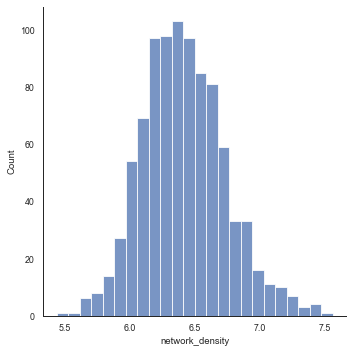

In [46]:
sns.displot(df.loc[:,'network_density']*100)

## Age

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


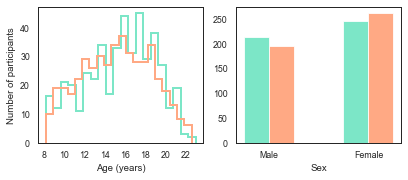

In [47]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[df['disc_repl'] == 0,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[0],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
sns.distplot(df.loc[df['disc_repl'] == 1,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[1]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df.loc[df['disc_repl'] == 0,'sex'] == 1), np.sum(df.loc[df['disc_repl'] == 0,'sex'] == 2)]
y_test = [np.sum(df.loc[df['disc_repl'] == 1,'sex'] == 1), np.sum(df.loc[df['disc_repl'] == 1,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar(r1, y_train, width = barWidth, color = cmap[0], label = labels[0])
axes[1].bar(r2, y_test, width = barWidth, color = cmap[1], label = labels[1])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([r + barWidth for r in range(len(y_train))])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0)

## Symptom dimensions

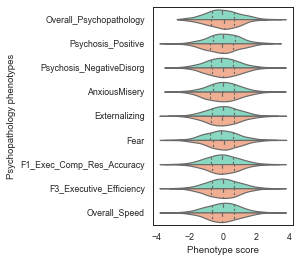

In [48]:
df_rc = pd.melt(df, id_vars = 'disc_repl', value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', hue='disc_repl', data=df_rc, palette = cmap, split=True, scale='width', inner = 'quartile', orient = 'h')
ax.get_legend().remove()
ax.set_yticklabels(phenos)
ax.set_ylabel('Psychopathology phenotypes')
ax.set_xlabel('Phenotype score')
f.savefig('symptoms_distributions.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0)